In [10]:
import time
import os
import io
from tqdm import tqdm
from qqdm import qqdm, format_str
import pandas as pd
import numpy as np
import random
import pickle
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import transformers
from datasets import load_dataset, load_from_disk
from transformers import AutoModel, AutoConfig, AutoTokenizer
from transformers import AdamW

# 忽略红色提示
import warnings
warnings.filterwarnings("ignore")

In [11]:
# from torchvision.models import ResNet50_Weights

# weights = ResNet50_Weights.IMAGENET1K_V2
# img_model = models.resnet50(weights=weights)

# torch.save(img_model.state_dict(), 'resnet50.pth')

In [12]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(7890)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('../models/hfl_rbt6')  # 可以考虑换成'bert-base-chinese'，建议下载到本地使用

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
class MultimodalDataset(Dataset):
    def __init__(self, data_file):
        with open(data_file, 'rb') as f:
            self.data = pickle.load(f)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 对图像进行归一化
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = [i for i in self.data[idx]["text"]]
        images = self.data[idx]["img"]
        label = self.data[idx]["label"]

        if len(images) > 1:
            processed_images = []
            for img_data in images:
                img = Image.open(io.BytesIO(img_data))
                img = self.transform(img)
                processed_images.append(img)
            images = torch.stack(processed_images)
        elif len(images) == 1:
            img = Image.open(io.BytesIO(images[0]))
            img = self.transform(img)
            images = img.unsqueeze(0)
        else:
            img = self.transform(Image.new('RGB', (224, 224), (0, 0, 0)))
            images = img.unsqueeze(0)

        return text, images, label

dataset = MultimodalDataset('train.pkl')

print(len(dataset), '\n')
for i in range(len(dataset)):
    tokens, images, labels = dataset[i]
    if len(images) > 1:
        print(len(images))
        print(images[0].shape)
        print(tokens)
        print(labels)
        break

# for i in tqdm(range(len(dataset))):
#     _, ima, _ = dataset[i]
#     for j in ima:
#         if j.shape[0] < 3:
#             print(j.shape)

7531 

4
torch.Size([3, 224, 224])
['3', '8', '6', '9', '1', '7', '6', '2', '7', '8', '1', '1', '7', '6', '4', '7', '|', '演', '员', '李', '彬', '强', '|', 'h', 't', 't', 'p', ':', '/', '/', 'w', 'e', 'i', 'b', 'o', '.', 'c', 'o', 'm', '/', '1', '3', '9', '8', '1', '2', '9', '0', '9', '4', '/', 'C', 't', '1', 'A', 'D', 'y', '3', 'L', 'N', '|', 'n', 'u', 'l', 'l', '|', '2', '0', '1', '5', '-', '0', '7', '-', '2', '7', ' ', '1', '1', ':', '1', '6', '|', 't', 'r', 'u', 'e', '|', '4', '5', '|', '2', '7', '|', '1', '6', '|', '1', '3', '9', '8', '1', '2', '9', '0', '9', '4', '|', '1', '|', '3', '2', '3', '7', '2', '|', '1', '8', '2', '2', '|', '1', '5', '0', '1', '|', '小', '米', '手', '机', '\n', '河', '南', '一', '家', '肯', '德', '基', '出', '售', '长', '了', '蛆', '的', '炸', '鸡', '腿', '，', '引', '起', '顾', '客', '不', '满', '，', '随', '后', '引', '发', '矛', '盾', '，', '最', '后', '河', '南', '市', '民', '，', '愤', '怒', '的', '将', '该', '店', '砸', '毁', '。', '德', '基', '相', '关', '负', '责', '人', '称', '损', '失', '超', '过', '1', '0', '0'

In [15]:
# def collate_fn(batch):
#     batch_texts = []
#     batch_images = []
#     batch_labels = []

#     # 遍历批次中的每个样本
#     for item in batch:
#         batch_texts.append(item[0])
#         batch_images.append(item[1].unsqueeze(0))
#         batch_labels.append(item[2])

#     batch_texts = tokenizer.batch_encode_plus(batch_texts,
#                                               truncation=True,
#                                               padding=True,
#                                               return_tensors='pt',
#                                               is_split_into_words=True,
#                                               max_length=512-2
#                                              )
#     batch_images = torch.stack(batch_images).squeeze(1)

#     batch_labels = torch.tensor(batch_labels)

#     return batch_texts.to(device), batch_images.to(device), batch_labels.to(device)

def collate_fn(batch):
    batch_texts = []
    batch_images = []
    batch_labels = []
    for item in batch:
        batch_texts.append(item[0])
        batch_images.append(item[1]) # 将每个样本的所有图片作为一个列表添加
        batch_labels.append(item[2])
    # 对文字进行预处理
    batch_texts = tokenizer.batch_encode_plus(batch_texts,
                                         truncation=True,
                                         padding=True,
                                         return_tensors='pt',
                                         is_split_into_words=True,
                                         max_length=512-2
                                        )
    # 标签
    batch_labels = torch.tensor(batch_labels)
    # 不在这里转换图像数据为张量，在模型的forward方法中处理
    return batch_texts.to(device), batch_images, batch_labels.to(device)

loader = DataLoader(dataset=dataset,
                    batch_size=8,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True)

i = 0
for data in loader:
    print(data)
    i += 1
    if i == 1:
        break

({'input_ids': tensor([[ 101,  124,  129,  ...,    0,    0,    0],
        [ 101,  124,  126,  ...,    0,    0,    0],
        [ 101,  124,  126,  ...,    0,    0,    0],
        ...,
        [ 101,  124,  125,  ...,    0,    0,    0],
        [ 101,  124,  126,  ..., 6760, 6585,  102],
        [ 101,  124,  129,  ...,    0,    0,    0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}, [tensor([[[[ 0.1768,  0.0741,  0.0398,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.2282,  0.1254, -0.0116,  ...,  2.2489,  2.248

In [16]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model_path, img_model_path):
        super(MultimodalClassifier, self).__init__()
        self.text_model = AutoModel.from_pretrained(text_model_path)
        self.img_model = models.resnet50()
        self.img_model.load_state_dict(torch.load(img_model_path))
        self.img_model.fc = nn.Identity()
        img_model_dim = 2048

        # 从预训练的文本模型配置中获取隐藏层的大小
        config = AutoConfig.from_pretrained(text_model_path)
        text_model_dim = config.hidden_size

        # 计算Transformer的输入维度，它是文本特征和图像特征维度的总和
        transformer_dim = text_model_dim + img_model_dim

        self.attention_layer = nn.MultiheadAttention(embed_dim=img_model_dim, num_heads=8)
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=transformer_dim,
                nhead=8,
                dim_feedforward=2048,
                dropout=0.1
            ),
            num_layers=6
        )

        self.classifier = nn.Sequential(
            nn.Linear(transformer_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1)  # Softmax函数，用于计算分类概率
        )

    def forward(self, input_ids, attention_mask, images):
        device = input_ids.device  # 确保设备一致

        # 处理文本特征
        text_features = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[0]
        text_features = text_features[:, 0, :]  # 取出CLS标记的特征

        # 处理图像特征
        img_features_list = []
        for img_batch in images:
            img_features = []
            for img in img_batch:
                img_feature = self.img_model(img.unsqueeze(0).to(device))  # 处理单张图片
                img_features.append(img_feature)
            img_features = torch.stack(img_features, dim=0).to(device)  # 堆叠成张量
            img_features, _ = self.attention_layer(img_features, img_features, img_features)  # 多头注意力
            img_features = img_features.mean(dim=0)  # 平均池化
            img_features_list.append(img_features)
        img_features = torch.cat(img_features_list, dim=0)  # 用cat

        # 合并文本和图像特征
        combined_features = torch.cat((text_features, img_features), dim=1).unsqueeze(0)

        # 通过Transformer编码器
        transformer_output = self.transformer_encoder(combined_features)

        # 分类
        logits = self.classifier(transformer_output.squeeze(0))

        return logits

In [ ]:
num_epochs = 3 # 训练轮数
best_loss = 99
model_path = "../model" # 模型存放路径
model = MultimodalClassifier('../models/hfl_rbt6', '../models/resnet50.pth').to(device)

criterion = nn.CrossEntropyLoss() # 交叉熵损失
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [20]:
model.train()
qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = []
    for batch in loader:
        batch_texts, batch_images, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
        loss = criterion(outputs, batch_labels)
        tot_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, os.path.join(model_path, 'FN_best.pth'))
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    torch.save(model, os.path.join(model_path, 'FN_last.pth'))

 Iters    Elapsed Time      Speed                                                                                       
  0/3           -             -                                                                                         
Description   0.0% |                                                                                                   | Iters    Elapsed Time      Speed    epoch   loss                                                                       
  1/3   00:08:32<00:17:05  0.00it/s   1/3   0.3197                                                                      
Description  33.3% |█████████████████████████████████                                                                  | Iters    Elapsed Time      Speed    epoch   loss                                                                       
  2/3   00:17:06<00:08:33  0.00it/s   2/3   0.3133                                                                      
Description  66.7% |██████████████

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def acc(model_path, test_path):
    with open(test_path, 'rb') as file:
        test_data = pickle.load(file)  # 加载测试数据
    model = torch.load(model_path, map_location=device)
    test_dataset = MultimodalDataset(test_path)
    test_loader = DataLoader(dataset=test_dataset,
                    batch_size=16,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True)  # 如果最后一个批次不足batch_size，则丢弃

    criterion = nn.CrossEntropyLoss()

    model.eval()
    correct = 0  # 正确预测的数量
    total = 0  # 总预测的数量
    total_loss = 0  # 总损失

    with torch.no_grad():
        for batch in test_loader:
            batch_texts, batch_images, batch_labels = batch
            outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
            # 计算损失
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()  # 累加损失

            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)  # 累加总预测数量
            correct += torch.sum(predicted == batch_labels).item()

    accuracy = correct / total
    test_loss = total_loss / total
    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}')

In [22]:
def recall(model_path, test_path): # 被模型正确识别为正类的样本数占所有实际为正类的样本数的比例
    with open(test_path, 'rb') as file:
        test_data = pickle.load(file)  # 加载测试数据
    model = torch.load(model_path, map_location=device)
    test_dataset = MultimodalDataset(test_path)
    test_loader = DataLoader(dataset=test_dataset,
                    batch_size=16,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True)  # 如果最后一个批次不足batch_size，则丢弃
    model.eval()
    TP = 0  # 真正例
    FN = 0  # 假负例

    with torch.no_grad():
        for batch in test_loader:
            batch_texts, batch_images, batch_labels = batch
            outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
            _, predicted = torch.max(outputs.data, 1)
            # 更新TP和FN
            TP += torch.sum((predicted == 1) & (batch_labels == 1)).item()
            FN += torch.sum((predicted == 0) & (batch_labels == 1)).item()

    recall_score = TP / (TP + FN)
    print(f'Recall: {recall_score:.4f}')

In [23]:
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [24]:
def plot_roc(model_path, test_path):
    with open(test_path, 'rb') as file:
        test_data = pickle.load(file)  # 加载测试数据
    model = torch.load(model_path, map_location=device)
    test_dataset = MultimodalDataset(test_path)
    test_loader = DataLoader(dataset=test_dataset,
                    batch_size=16,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True)  # 如果最后一个批次不足batch_size，则丢弃
    y_true = []
    y_scores = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch_texts, batch_images, batch_labels = batch
            outputs = model(batch_texts['input_ids'], batch_texts['attention_mask'], batch_images)
            y_true.extend(batch_labels.tolist())
            y_scores.extend(outputs[:, 1].tolist())  # 正类标签为1

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('误报率')
    plt.ylabel('真正例率')
    plt.title('ROC曲线')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
acc("..\models\FN_best.pth", "test.pkl")

Test Accuracy: 1.0000, Test Loss: 0.0196


In [ ]:
recall("..\models\FN_best.pth", "test.pkl")

Recall: 1.0000


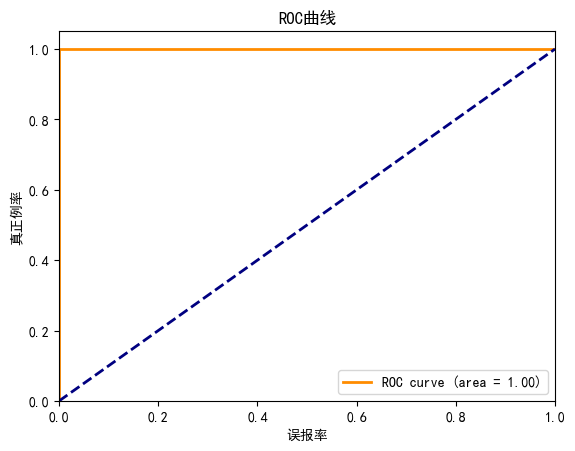

In [ ]:
plot_roc("..\models\FN_best.pth", "test.pkl")